# 2.1: 1D Heat Equation - PyTorch Implementation

This notebook solves the 1D heat equation using pure PyTorch instead of DeepXDE.
The heat equation is a canonical example of a parabolic PDE.

### Problem Definition:
- **PDE**: $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$
- **Domain**: $x \in [0, 1]$, $t \in [0, 1]$
- **Initial Condition**: $u(x, 0) = \sin(\pi x)$
- **Boundary Conditions**:
    - $u(0, t) = 0$
    - $u(1, t) = 0$
- **Thermal Diffusivity**: $\alpha = 0.1 / \pi$
- **Analytical Solution**: $u(x,t) = \sin(\pi x) e^{-\alpha \pi^2 t}$

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set device and style
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
sns.set_style("whitegrid")

# Problem parameters
alpha = 0.1 / np.pi
print(f"Thermal diffusivity α = {alpha:.6f}")

Using device: cuda
Thermal diffusivity α = 0.031831


## 1. Neural Network Architecture

In [38]:
class HeatPINN(nn.Module):
    """Physics-Informed Neural Network for Heat Equation"""
    
    def __init__(self, hidden_dim=20, num_layers=3):
        super(HeatPINN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(2, hidden_dim))  # Input: (x, t)
        
        for _ in range(num_layers):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))  # Output: u(x,t)
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)

# Create model
model = HeatPINN(hidden_dim=20, num_layers=3).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(model)

Model parameters: 1341
HeatPINN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


## 2. Domain Sampling Functions

In [39]:
def sample_domain_points(num_points, device=device):
    """Sample points from the interior domain"""
    x = torch.rand(num_points, 1, device=device)  # x ∈ [0, 1]
    t = torch.rand(num_points, 1, device=device)  # t ∈ [0, 1]
    return torch.cat([x, t], dim=1)

def sample_boundary_points(num_points, device=device):
    """Sample points from spatial boundaries (x=0 and x=1)"""
    t = torch.rand(num_points, 1, device=device)  # t ∈ [0, 1]
    
    # Left boundary: x = 0
    x_left = torch.zeros(num_points//2, 1, device=device)
    t_left = t[:num_points//2]
    left_boundary = torch.cat([x_left, t_left], dim=1)
    
    # Right boundary: x = 1
    x_right = torch.ones(num_points//2, 1, device=device)
    t_right = t[num_points//2:num_points//2 + num_points//2]
    right_boundary = torch.cat([x_right, t_right], dim=1)
    
    return torch.cat([left_boundary, right_boundary], dim=0)

def sample_initial_points(num_points, device=device):
    """Sample points from initial condition (t=0)"""
    x = torch.rand(num_points, 1, device=device)  # x ∈ [0, 1]
    t = torch.zeros(num_points, 1, device=device)  # t = 0
    return torch.cat([x, t], dim=1)

# Sample points
num_domain = 2540
num_boundary = 80
num_initial = 160

domain_points = sample_domain_points(num_domain, device)
boundary_points = sample_boundary_points(num_boundary, device)
initial_points = sample_initial_points(num_initial, device)

print(f"Domain points: {domain_points.shape}")
print(f"Boundary points: {boundary_points.shape}")
print(f"Initial points: {initial_points.shape}")

Domain points: torch.Size([2540, 2])
Boundary points: torch.Size([80, 2])
Initial points: torch.Size([160, 2])


## 3. Automatic Differentiation Utilities

In [40]:
def compute_derivatives(u, points):
    """Compute partial derivatives of u with respect to x and t
    
    Args:
        u: Network output u(x,t)
        points: Input points [x, t]
    
    Returns:
        u_t: ∂u/∂t
        u_x: ∂u/∂x
        u_xx: ∂²u/∂x²
    """
    # First derivatives
    grad = torch.autograd.grad(
        outputs=u,
        inputs=points,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    u_x = grad[:, 0:1]  # ∂u/∂x
    u_t = grad[:, 1:2]  # ∂u/∂t
    
    # Second derivative ∂²u/∂x²
    u_xx = torch.autograd.grad(
        outputs=u_x,
        inputs=points,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 0:1]
    
    return u_t, u_x, u_xx

## 4. Loss Functions

In [ ]:
def analytical_solution(points):
    """Analytical solution: u(x,t) = sin(πx) * exp(-α*π²*t)"""
    x = points[:, 0:1]
    t = points[:, 1:2]
    return torch.sin(np.pi * x) * torch.exp(-alpha * np.pi**2 * t)

def initial_condition(points):
    """Initial condition: u(x,0) = sin(πx)"""
    x = points[:, 0:1]
    return torch.sin(np.pi * x)

def boundary_condition(points):
    """Boundary condition: u(0,t) = u(1,t) = 0"""
    return torch.zeros(points.shape[0], 1, device=points.device)

def compute_losses(model, domain_points, boundary_points, initial_points):
    """Compute all loss components"""
    
    # Enable gradients for domain points
    domain_points.requires_grad_(True)
    
    # 1. PDE Loss: ∂u/∂t - α∇²u = 0
    u_domain = model(domain_points)
    u_t, u_x, u_xx = compute_derivatives(u_domain, domain_points)
    
    pde_residual = u_t - alpha * u_xx
    loss_pde = torch.mean(pde_residual**2)
    
    # 2. Boundary Loss: u(0,t) = u(1,t) = 0
    u_boundary = model(boundary_points)
    bc_target = boundary_condition(boundary_points)
    loss_boundary = torch.mean((u_boundary - bc_target)**2)
    
    # 3. Initial Condition Loss: u(x,0) = sin(πx)
    u_initial = model(initial_points)
    ic_target = initial_condition(initial_points)
    loss_initial = torch.mean((u_initial - ic_target)**2)
    
    # Total loss
    total_loss = loss_pde + loss_boundary + loss_initial
    
    return {
        'total': total_loss,
        'pde': loss_pde,
        'boundary': loss_boundary,
        'initial': loss_initial
    }

# Test loss computation
# The with torch.no_grad() block is removed because compute_losses
# internally calls compute_derivatives, which requires autograd to be enabled.
losses = compute_losses(model, domain_points, boundary_points, initial_points)
print("Initial losses:")
for key, value in losses.items():
    print(f"  {key}: {value.item():.6f}")



Initial losses:
  total: 1.195685
  pde: 0.344161
  boundary: 0.706536
  initial: 0.144987


## 5. Training

In [42]:
def train_model(model, domain_points, boundary_points, initial_points, 
                epochs=15000, lr=1e-3, print_every=1000):
    """Train the PINN model"""
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    print(f"Starting training for {epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Compute losses
        losses = compute_losses(model, domain_points, boundary_points, initial_points)
        total_loss = losses['total']
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Record losses
        loss_history.append({
            'epoch': epoch,
            'total': total_loss.item(),
            'pde': losses['pde'].item(),
            'boundary': losses['boundary'].item(),
            'initial': losses['initial'].item()
        })
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch {epoch+1:5d}/{epochs} | "
                  f"Total: {total_loss.item():.2e} | "
                  f"PDE: {losses['pde'].item():.2e} | "
                  f"BC: {losses['boundary'].item():.2e} | "
                  f"IC: {losses['initial'].item():.2e} | "
                  f"Time: {elapsed_time:.1f}s")
            start_time = time.time()
    
    return loss_history

# Train the model
loss_history = train_model(model, domain_points, boundary_points, initial_points, 
                          epochs=15000, lr=1e-3, print_every=1000)

Starting training for 15000 epochs...
Epoch  1000/15000 | Total: 1.01e-03 | PDE: 4.98e-04 | BC: 3.26e-04 | IC: 1.88e-04 | Time: 9.2s
Epoch  2000/15000 | Total: 9.76e-05 | PDE: 6.17e-05 | BC: 1.92e-05 | IC: 1.66e-05 | Time: 7.2s
Epoch  3000/15000 | Total: 5.00e-05 | PDE: 3.13e-05 | BC: 1.07e-05 | IC: 7.90e-06 | Time: 7.6s
Epoch  4000/15000 | Total: 3.19e-05 | PDE: 2.22e-05 | BC: 6.52e-06 | IC: 3.19e-06 | Time: 7.7s
Epoch  5000/15000 | Total: 2.08e-05 | PDE: 1.65e-05 | BC: 3.23e-06 | IC: 1.06e-06 | Time: 7.9s
Epoch  6000/15000 | Total: 1.71e-05 | PDE: 1.38e-05 | BC: 2.56e-06 | IC: 6.59e-07 | Time: 7.2s
Epoch  7000/15000 | Total: 2.58e-05 | PDE: 1.31e-05 | BC: 8.48e-06 | IC: 4.15e-06 | Time: 8.6s
Epoch  8000/15000 | Total: 1.12e-05 | PDE: 1.00e-05 | BC: 1.06e-06 | IC: 1.48e-07 | Time: 7.8s
Epoch  9000/15000 | Total: 5.35e-04 | PDE: 5.64e-05 | BC: 2.93e-04 | IC: 1.86e-04 | Time: 6.6s
Epoch 10000/15000 | Total: 9.01e-06 | PDE: 8.17e-06 | BC: 7.54e-07 | IC: 9.11e-08 | Time: 6.7s
Epoch 11000/

## 6. Visualization and Validation

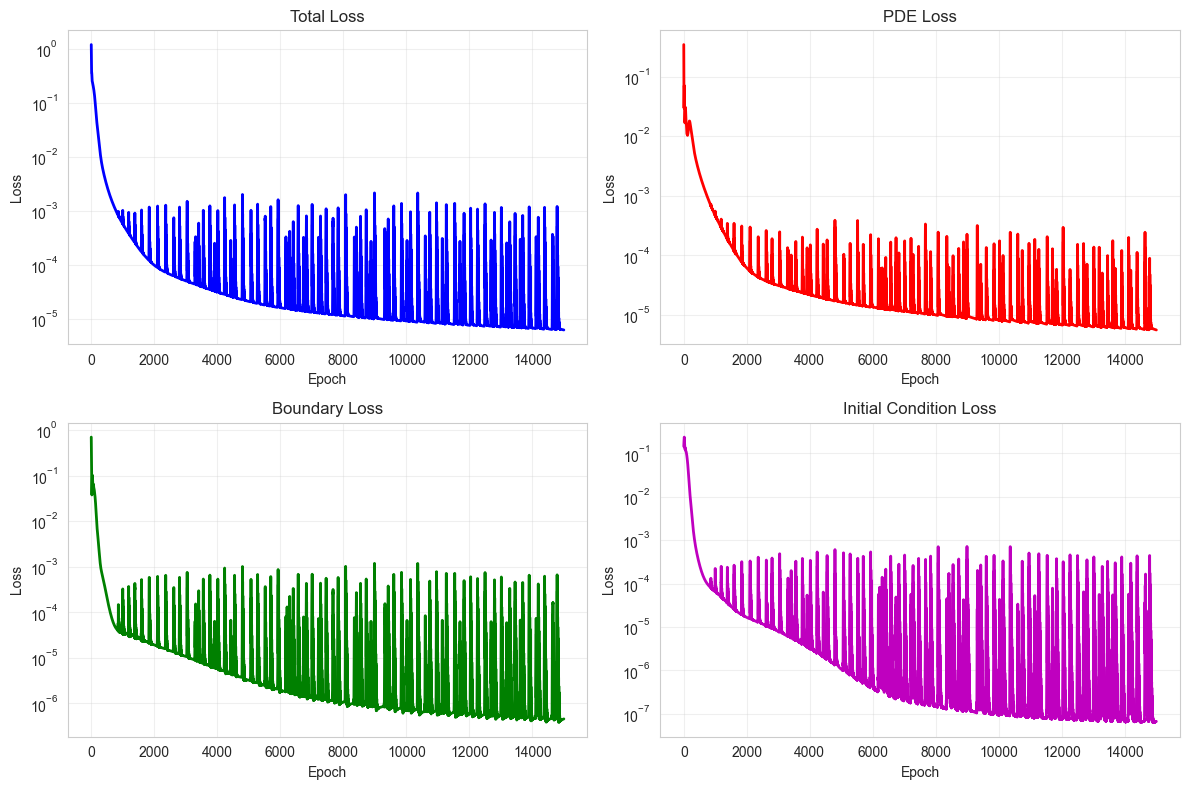

In [43]:
def plot_loss_history(loss_history):
    """Plot training loss history"""
    epochs = [h['epoch'] for h in loss_history]
    total_losses = [h['total'] for h in loss_history]
    pde_losses = [h['pde'] for h in loss_history]
    boundary_losses = [h['boundary'] for h in loss_history]
    initial_losses = [h['initial'] for h in loss_history]
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, total_losses, 'b-', linewidth=2)
    plt.yscale('log')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, pde_losses, 'r-', linewidth=2)
    plt.yscale('log')
    plt.title('PDE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, boundary_losses, 'g-', linewidth=2)
    plt.yscale('log')
    plt.title('Boundary Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, initial_losses, 'm-', linewidth=2)
    plt.yscale('log')
    plt.title('Initial Condition Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot loss history
plot_loss_history(loss_history)

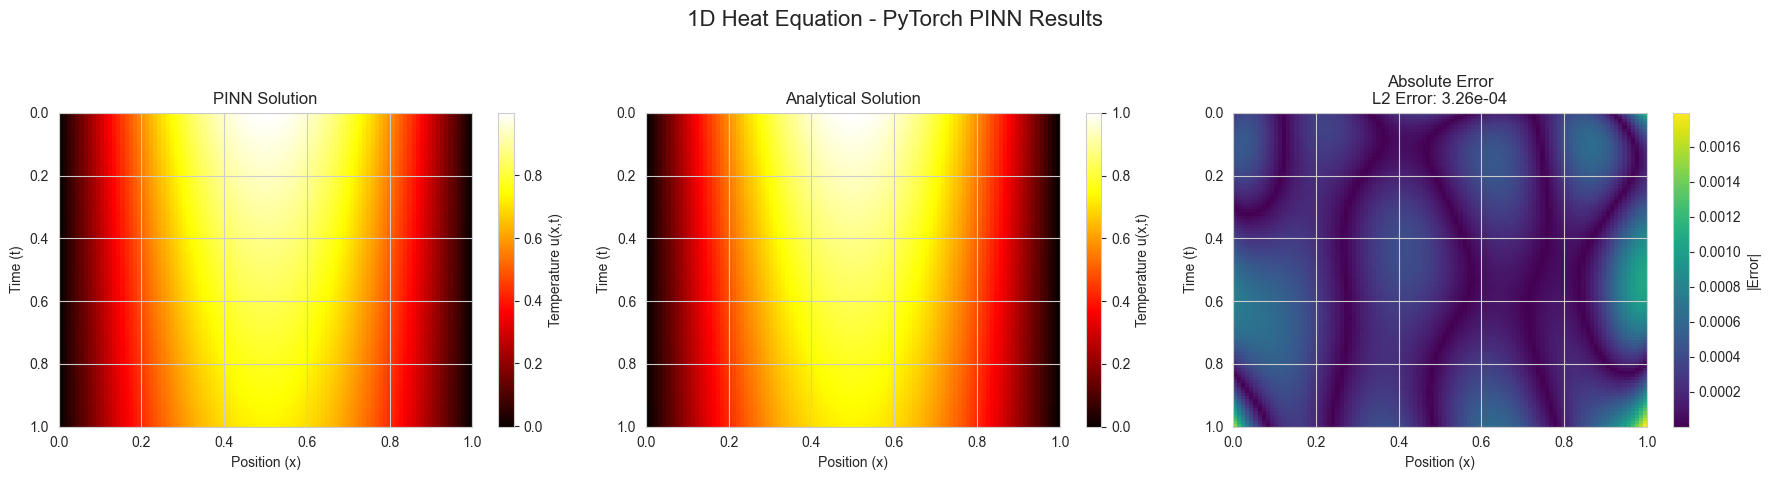

L2 Absolute Error: 3.260487e-04
L2 Relative Error: 5.377071e-04


In [44]:
def visualize_solution(model, resolution=101):
    """Visualize the solution as a heatmap"""
    model.eval()
    
    # Create grid for visualization
    x = torch.linspace(0, 1, resolution)
    t = torch.linspace(0, 1, resolution)
    X, T = torch.meshgrid(x, t, indexing='ij')
    
    # Flatten for model prediction
    xt_test = torch.stack([X.flatten(), T.flatten()], dim=1).to(device)
    
    # Predict solution
    with torch.no_grad():
        u_pred = model(xt_test).cpu()
    U_pred = u_pred.reshape(resolution, resolution)
    
    # Analytical solution
    u_analytical = analytical_solution(xt_test).cpu()
    U_analytical = u_analytical.reshape(resolution, resolution)
    
    # Compute error
    error = torch.abs(U_pred - U_analytical)
    l2_error = torch.sqrt(torch.mean((U_pred - U_analytical)**2))
    l2_relative = l2_error / torch.sqrt(torch.mean(U_analytical**2))
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PINN Solution
    im1 = axes[0].imshow(U_pred.T, extent=[0, 1, 1, 0], aspect='auto', cmap='hot')
    axes[0].set_title('PINN Solution')
    axes[0].set_xlabel('Position (x)')
    axes[0].set_ylabel('Time (t)')
    plt.colorbar(im1, ax=axes[0], label='Temperature u(x,t)')
    
    # Analytical Solution
    im2 = axes[1].imshow(U_analytical.T, extent=[0, 1, 1, 0], aspect='auto', cmap='hot')
    axes[1].set_title('Analytical Solution')
    axes[1].set_xlabel('Position (x)')
    axes[1].set_ylabel('Time (t)')
    plt.colorbar(im2, ax=axes[1], label='Temperature u(x,t)')
    
    # Error
    im3 = axes[2].imshow(error.T, extent=[0, 1, 1, 0], aspect='auto', cmap='viridis')
    axes[2].set_title(f'Absolute Error\nL2 Error: {l2_error:.2e}')
    axes[2].set_xlabel('Position (x)')
    axes[2].set_ylabel('Time (t)')
    plt.colorbar(im3, ax=axes[2], label='|Error|')
    
    plt.suptitle('1D Heat Equation - PyTorch PINN Results', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print(f"L2 Absolute Error: {l2_error:.6e}")
    print(f"L2 Relative Error: {l2_relative:.6e}")
    
    return l2_error.item(), l2_relative.item()

# Visualize results
l2_abs, l2_rel = visualize_solution(model)